# Relevant Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Preprocess Data

### Load RTT Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Generate subsets

In [3]:
def bin_append(set_ree, count, pset_size):
    intersect_val = 1
    subset = []

    while(intersect_val < pset_size):
        if count & intersect_val:
            index = int(math.log(intersect_val, 2))
            subset.append(set_ree[index])
        
        intersect_val *= 2

    return subset

def gen_power_set(set_ree):
    power = []
    count = 0

    pset_size = int(2 ** len(set_ree))

    for i in range(pset_size):
        power.append(bin_append(set_ree, count, pset_size))
        count = count + 1

    power.sort(key = lambda x : len(x))
    return power

In [4]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)

a_search = [0.01, 0.1, 1]
l_search = [10, 10, 10]
history = dict()

'''
context_set = [0, 1, 2, 3, 4]
context_elements = gen_power_set(context_set)
del context_elements[0]
'''
context_elements = [
    [0, 1, 2, 3, 4],
    [1, 2, 3],
    [1, 2, 3, 4],
    [0, 2, 3, 4],
    [0, 1, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 2, 3]
]

In [5]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()

count = 1
for context in context_elements:
    #os.makedirs(f'history/ablation/{context}')
    al_zip = zip(a_search, l_search)
    for a, l in al_zip:
        #print(context)
        print(f'Training Model {count}')
        fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
        fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
        fed.SetTestData({'Data': X, 'Labels': y})
        fed.SetContextElements(context)
        Mt = (np.ones(50) * 5).astype('int32')
        w, b = fed.ConFeddi(a, l, rounds = 50, Mt = Mt)
        mse = fed.val_loss()
        times = fed.GetLog()
        history[(a, l, tuple(context))] = (mse, times)
        count += 1

        #w = np.asanyarray(w, dtype = object)
        #b = np.asanyarray(b, dtype = object)
        #np.save(f'history/ablation/{context}/{a}-{l}w.npy', w)
        #np.save(f'history/ablation/{context}/{a}-{l}b.npy', b)
        #np.save(f'history/ablation/{context}/{a}-{l}mse.npy', mse)
        #np.save(f'history/ablation/{context}/{a}-{l}mae.npy', mae)
        print()



Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

In [6]:
fedavg_mse = np.load('history/important baselines/fedavg_mse_50.npy')
fedavg_log = np.load('history/important baselines/fedavg_log_50.npy')

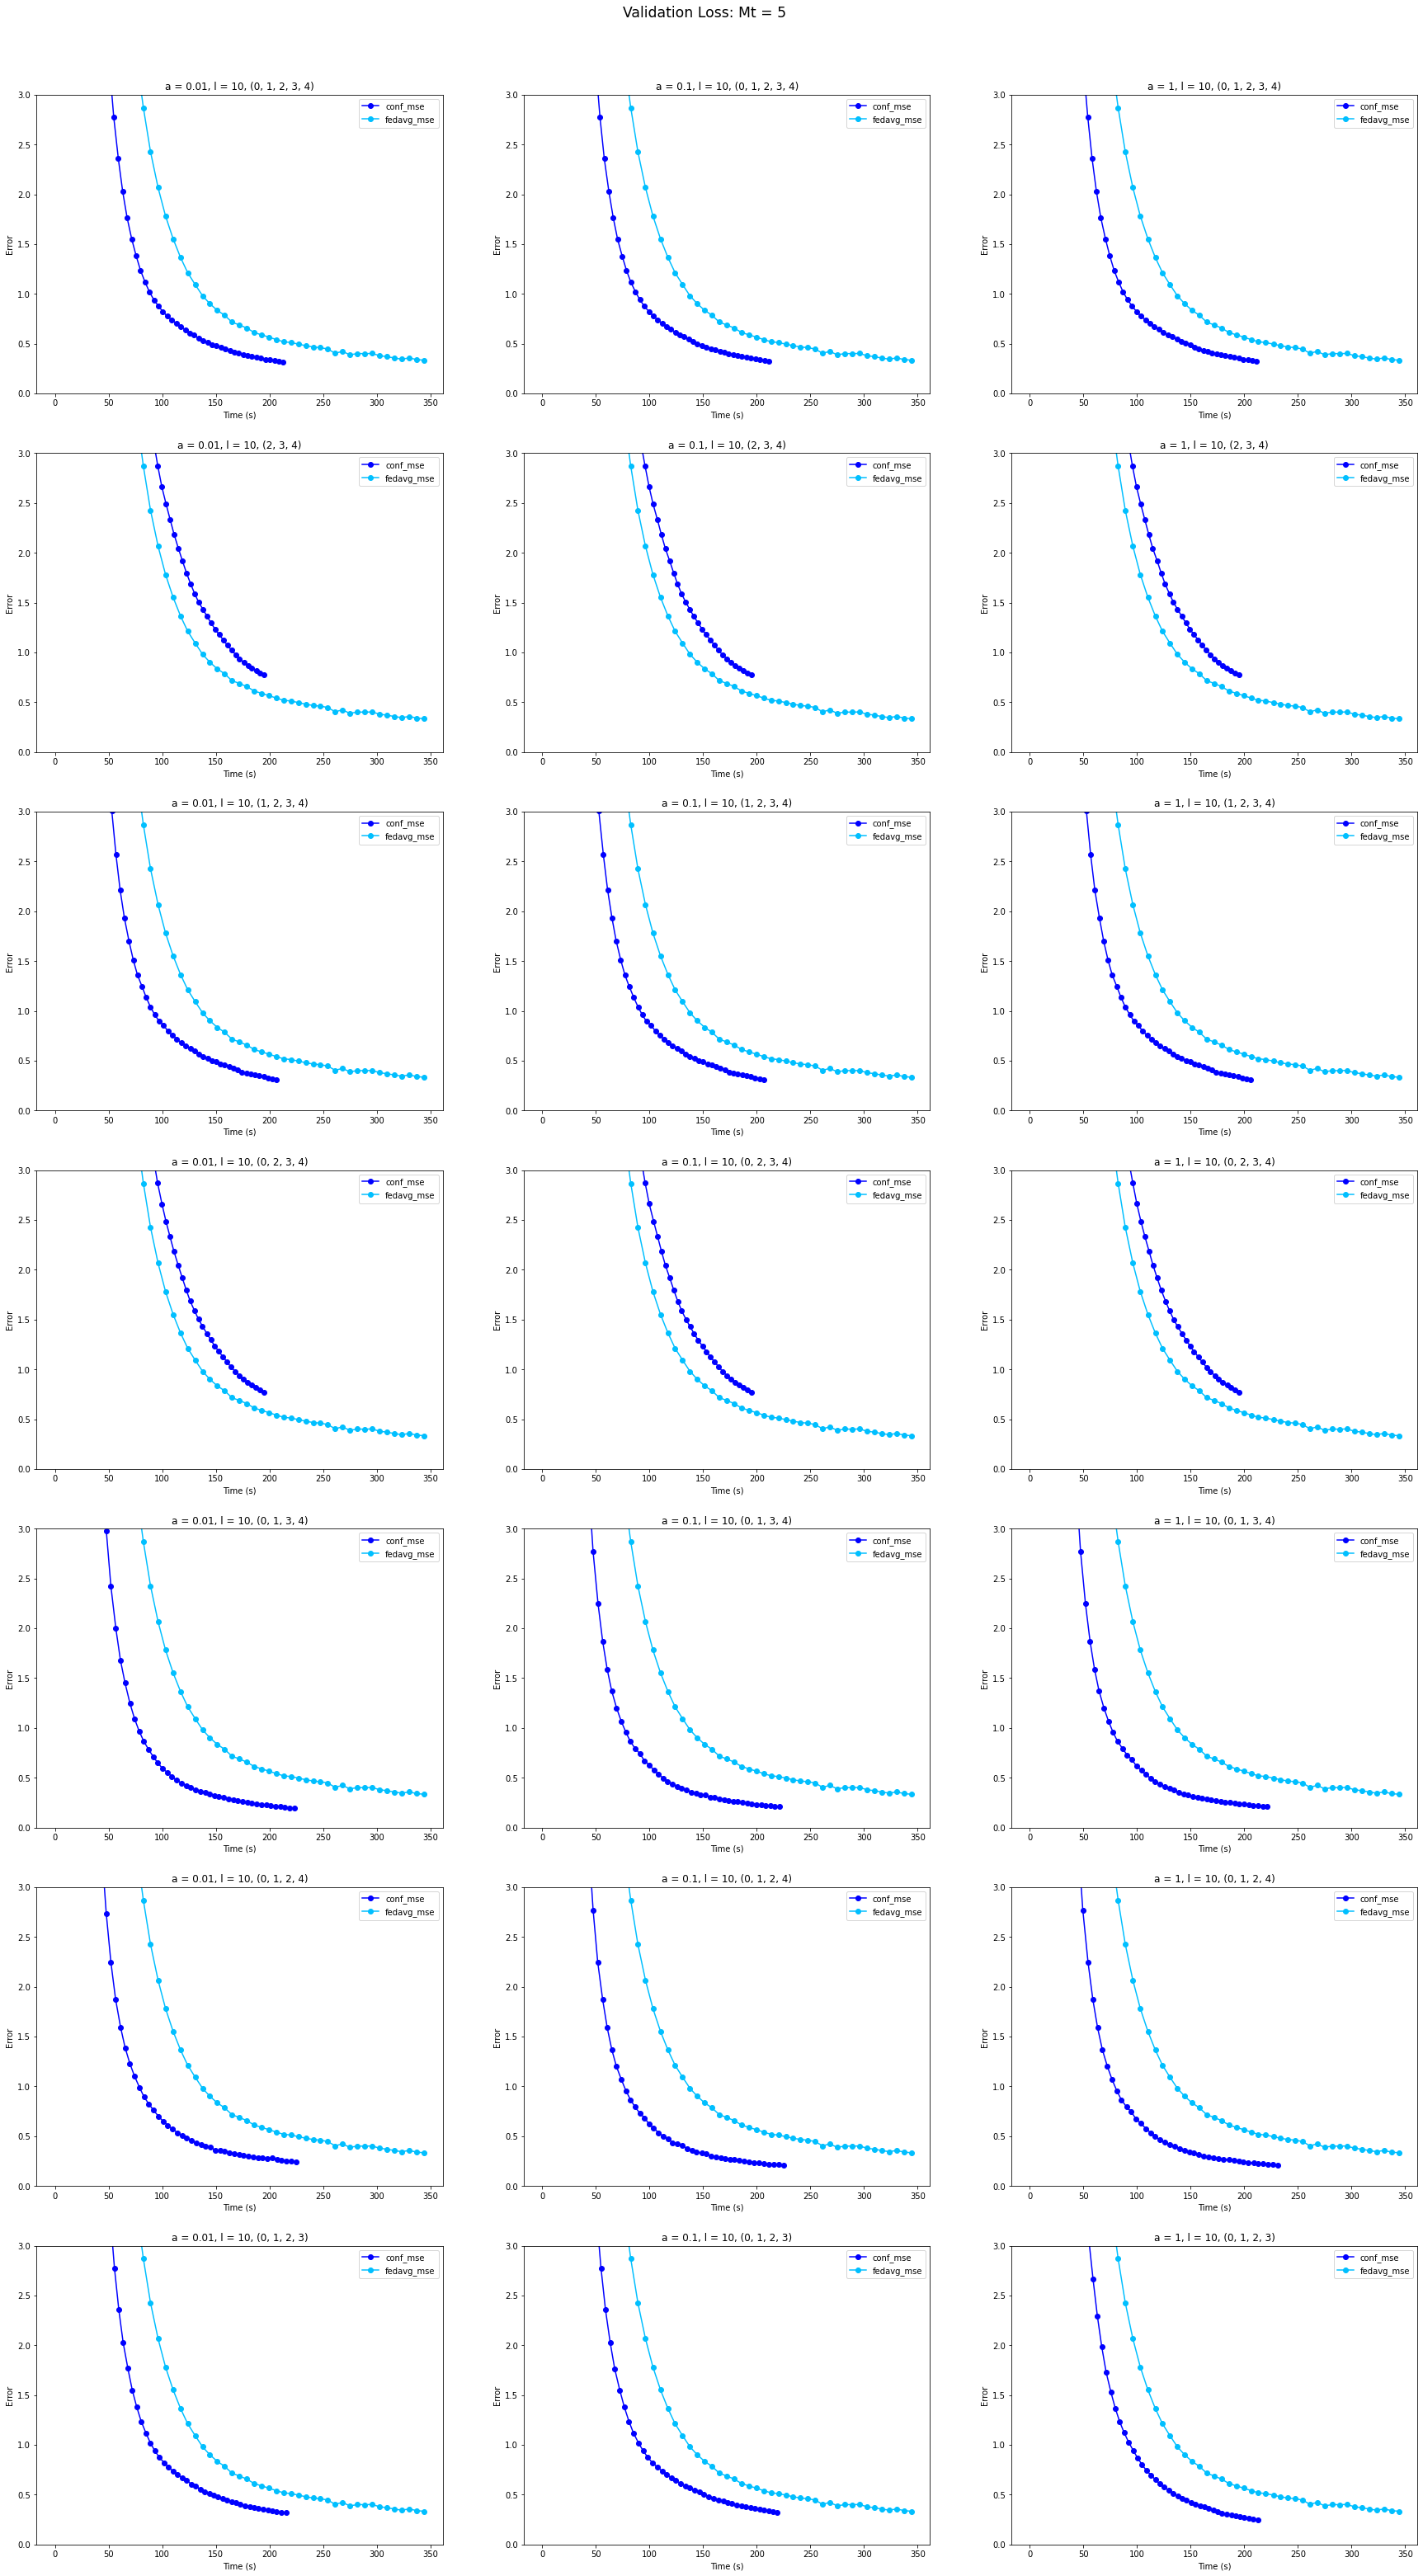

In [12]:
r, c, = 7, 3
fig = plt.figure(figsize = (30, 50))
plt.suptitle('Validation Loss: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

plot = 1
for run in history.items():
    a, l, context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')

    # When using final a and l, change title to Remove <specific context>
    plt.title(f'a = {a}, l = {l}, {context}')
    plt.ylim(0, 3)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    plot += 1

    

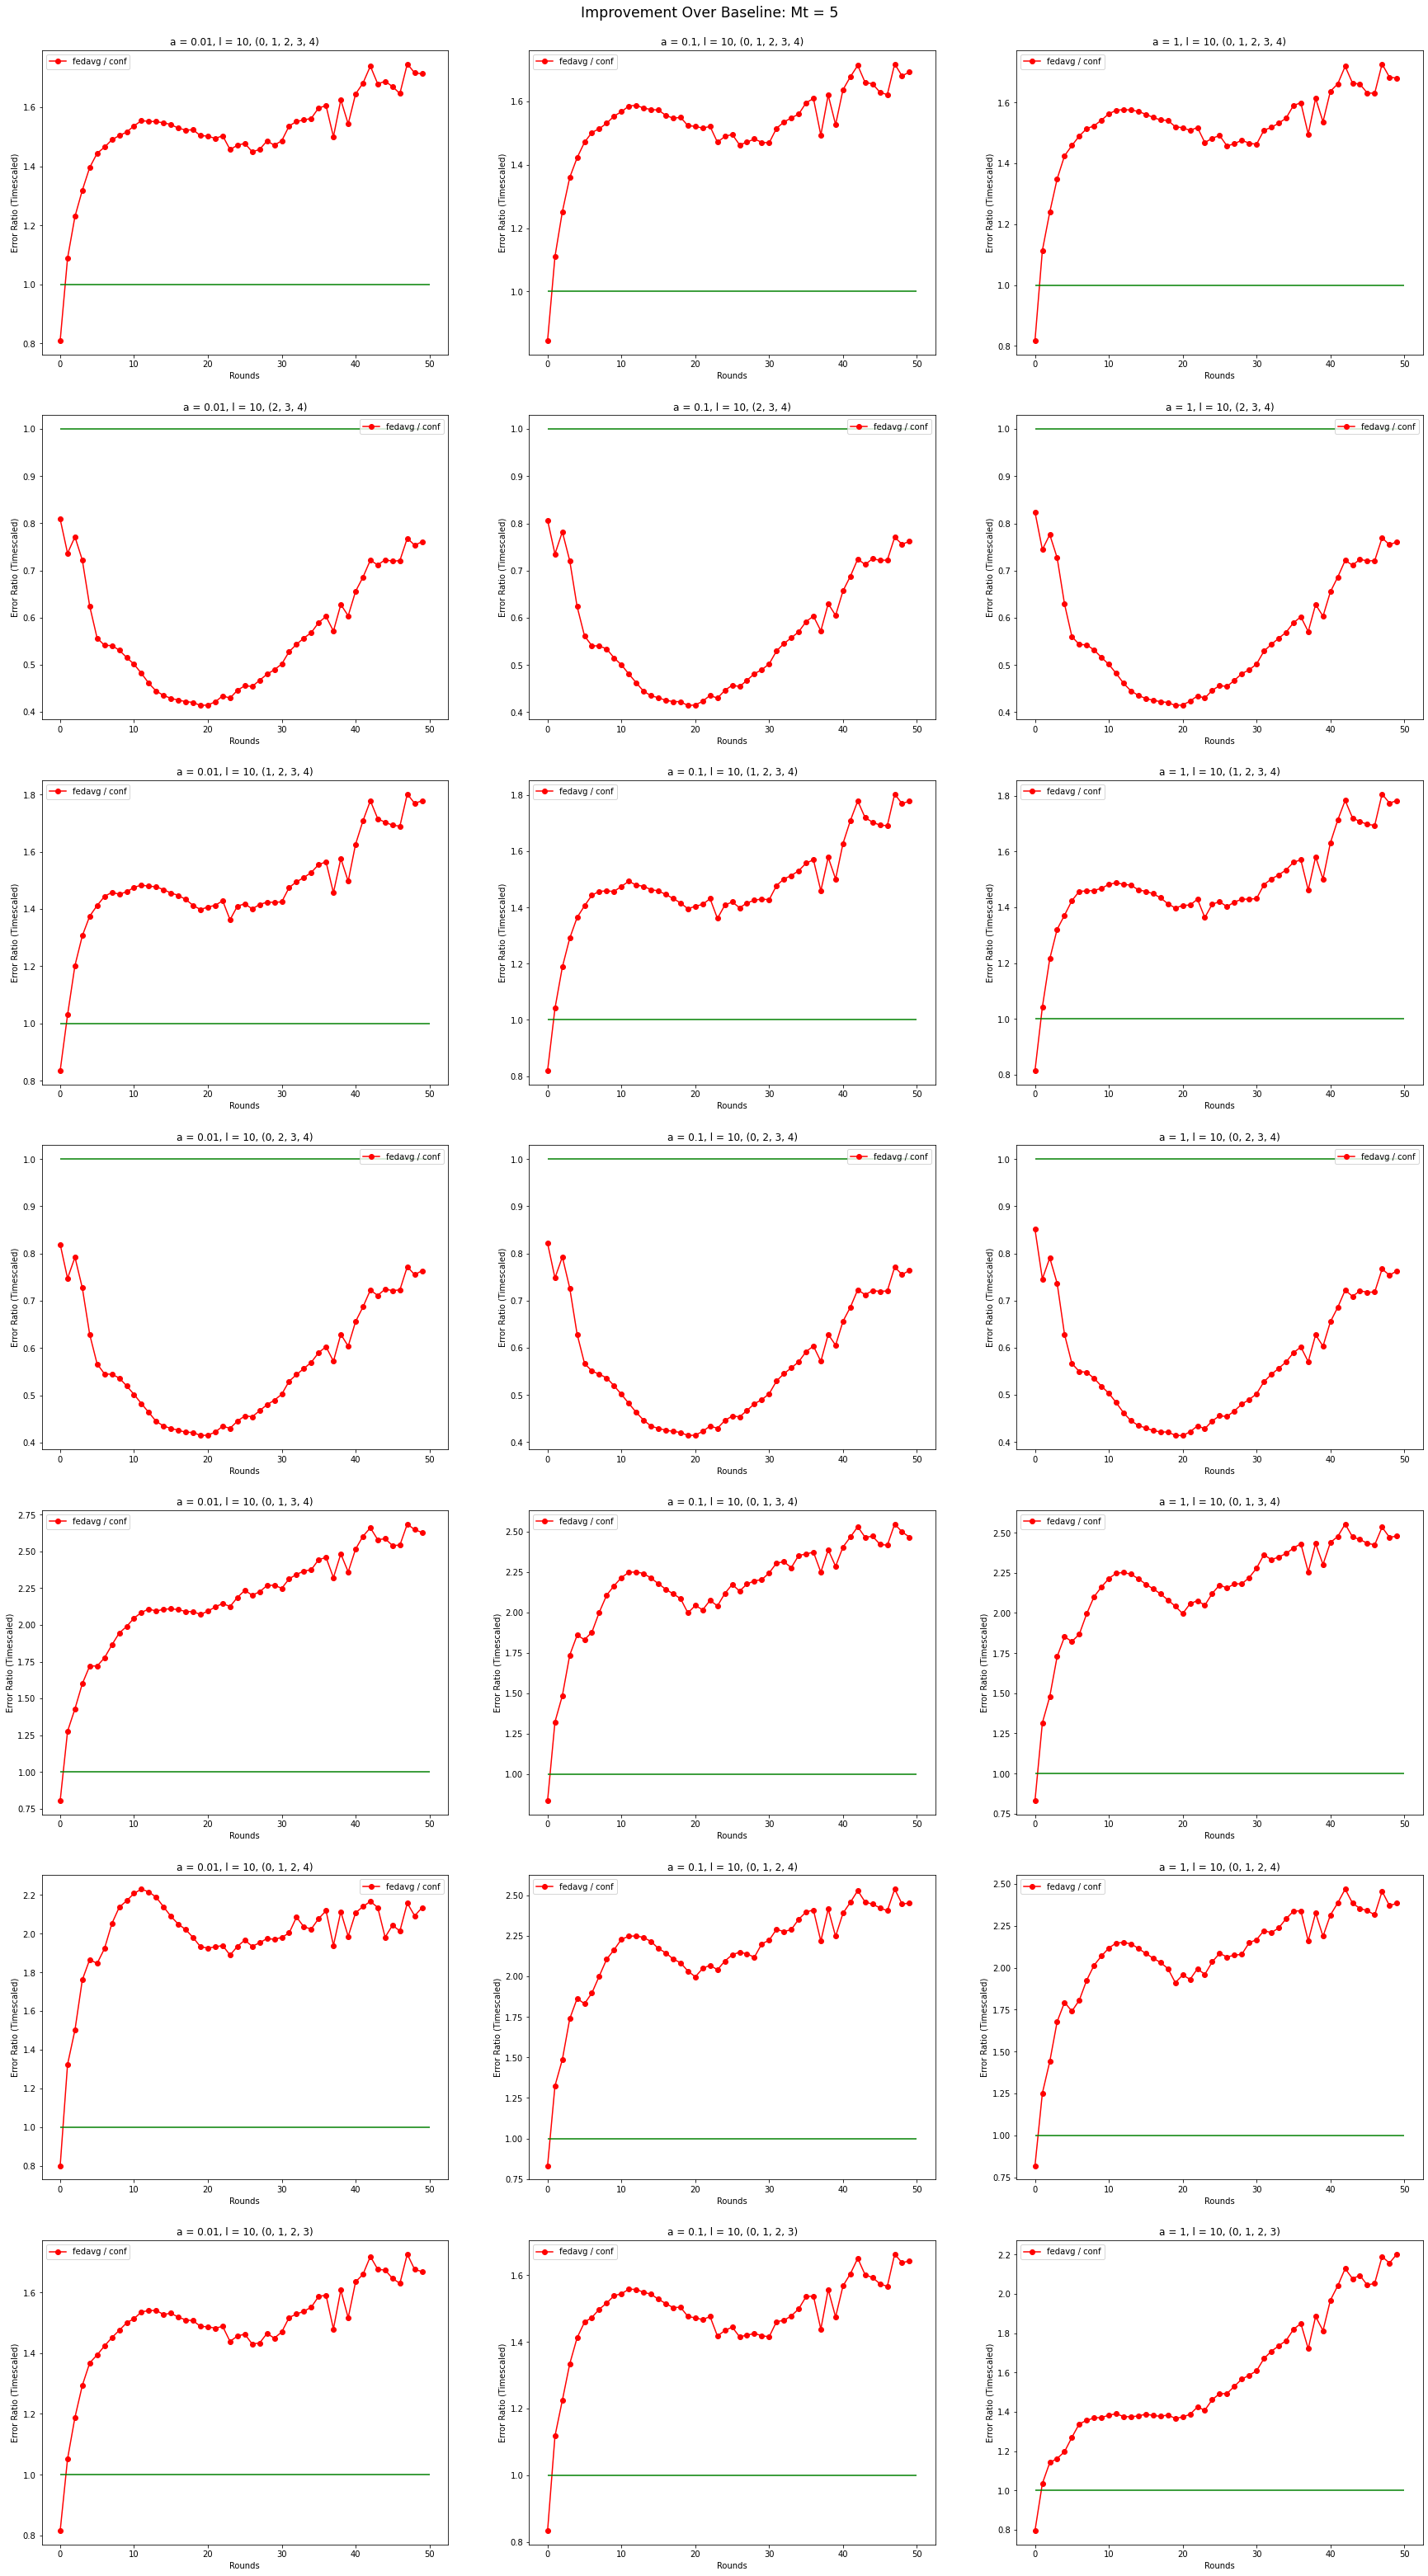

In [21]:
r, c, = 7, 3
fig = plt.figure(figsize = (30, 50))
plt.suptitle('Improvement Over Baseline: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.965)

plot = 1
for run in history.items():
    a, l, context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot((fedavg_log[1:] / time[1:]) * (np.array(fedavg_mse[1:]) / np.array(err[1:])), color = 'red', label = 'fedavg / conf', marker = 'o')
    plt.title(f'a = {a}, l = {l}, {context}')
    plt.ylabel('Error Ratio (Timescaled)')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green')
    plt.legend()

    plot += 1